In [18]:
import os
import pandas as pd
import metrics as mt
import os
import json
import numpy as np

ROOT_DIR = "/home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Results"

In [38]:
dataset_name = "N_minus_O"

with open(os.path.join(ROOT_DIR, f"ibench_{dataset_name}_ig_test.json")) as jf:
    ig_results = json.load(jf)
with open(os.path.join(ROOT_DIR, f"ibench_{dataset_name}_molgx_test.json")) as jf:
    molgx_results = json.load(jf)
with open(os.path.join(ROOT_DIR, f"ibench_{dataset_name}_subgx_test.json")) as jf:
    subgx_results = json.load(jf)
with open(os.path.join(ROOT_DIR, f"ibench_{dataset_name}_true_test.json")) as jf:
    true_results = json.load(jf)

In [43]:
smiles = list(subgx_results.keys())
d = {"smiles": [], "lbls": [], "atom_imp": []}
for sm in smiles:
    d["smiles"].append(sm)
    d["lbls"].append(true_results[sm])
    d["atom_imp"].append(subgx_results[sm])
d = pd.DataFrame.from_dict(d)
data = {
    "molecule": [],
    "atom_pred": [],
    "atom": [],
    "lbl": [],
}
for i, row in d.iterrows():
    if len(row["lbls"]) == len(row["atom_imp"]):
        data["molecule"] += [row["smiles"]] * len(row["lbls"])
        data["lbl"] += row["lbls"]
        data["atom_pred"] += row["atom_imp"]
        data["atom"] += list(range(len(row["lbls"])))

df = pd.DataFrame(data)
df['lbl'] = pd.to_numeric(df['lbl'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   molecule   1537 non-null   object
 1   atom_pred  1537 non-null   int64 
 2   atom       1537 non-null   int64 
 3   lbl        1537 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 48.2+ KB


In [44]:
auc = mt.calc_auc(df, which_lbls="positive", contrib_col_name="atom_pred")
auc['auc_pos'].mean()

np.float64(0.6182365273615275)

In [ ]:
molgx N 0.99 N_O 0.98 N_minus_O 0.97
subgx N 0.58 N_O 0.4 N_minus_O 0.61
ig N 0.99 N_O 0.97 N_minus_O 0.94



In [40]:
folder = "/home/cairne/WorkSpace/molgraphX/Output/ibench_N_contribs/ig"
data = []
for filename in os.listdir(folder):
    with open(f"{folder}/{filename}", "r") as f:
        data.append(json.load(f))
df = pd.DataFrame(data)
print(df.shape)
df.head(1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/cairne/WorkSpace/molgraphX/Output/ibench_N_contribs/ig'

In [ ]:
data = {
    "molecule": [],
    "atom_pred": [],
    "atom": [],
    "lbl": [],
}

for i, row in df.iterrows():
    assert len(row["lbls"]) == len(row["ig_atom_importance"]), f"Molecule {row['smiles']} has {len(row['lbls'])} labels and {len(row['ig_atom_importance'])} scores"
    data["molecule"] += [row["smiles"]] * len(row["lbls"])
    data["lbl"] += row["lbls"]
    data["atom_pred"] += normalize(row["ig_atom_importance"])
    data["atom"] += list(range(len(row["lbls"])))

df = pd.DataFrame(data)
df["contribution"] = df.groupby("molecule")["atom_pred"].transform(
    lambda x: -(x - x.mean()) / x.std() if x.std() > 0 else x - x.mean()
)

print(df.shape)
df.head(1)

(4171, 5)


,molecule,atom_pred,atom,lbl,contribution
0,C=CN(C)N=O,-0.289399,0,0.0,0.264184


In [14]:
df

,molecule,atom_pred,atom,lbl,contribution
0,C=CN(C)N=O,-0.289399,0,0.0,0.264184
1,C=CN(C)N=O,-0.539332,1,0.0,0.492341
2,C=CN(C)N=O,1.300957,2,1.0,-1.187607
3,C=CN(C)N=O,0.083176,3,0.0,-0.075929
4,C=CN(C)N=O,1.095565,4,1.0,-1.000110
...,...,...,...,...,...
4166,CCCOc1ccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CCc2c...,0.462265,32,0.0,-0.455977
4167,CCCOc1ccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CCc2c...,-0.962810,33,0.0,0.949715
4168,CCCOc1ccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CCc2c...,-0.913984,34,0.0,0.901553
4169,CCCOc1ccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CCc2c...,0.262770,35,0.0,-0.259196


In [15]:
auc = mt.calc_auc(df, which_lbls="positive", contrib_col_name="contribution")

In [16]:
auc

{'auc_pos': molecule
 Brc1ccc(OC[C@H]2CCN2)cn1                           0.000000
 C#CC(C)(CC)OC(N)=O                                 0.000000
 C/C(=N\OC(=O)Nc1ccccc1)c1cccc(-c2ccccc2)c1         0.000000
 C/C=C(\NC(=O)CC)C(=O)O                             0.000000
 C/N=c1\ccc(-c2ccc(N3CC(CNC(C)=O)OC3=O)cc2)ccc1O    0.000000
                                                      ...   
 Oc1ccc(Cn2ccnc2)cc1                                0.000000
 Oc1ccccc1-c1n[nH]c(=S)o1                           0.090909
 Sc1ccccc1-c1c[nH]cn1                               0.100000
 c1cc2c(cnc3cscc32)s1                               0.000000
 c1ccc(-c2nc3cc4ccccc4c-3c[nH]2)cc1                 0.000000
 Length: 242, dtype: float64}

In [17]:
import numpy as np

np.array(list(auc.values())).mean()

np.float64(0.004679988466417348)

In [18]:
auc["auc_pos"].sort_values(ascending=True).tail(10).index.tolist()

['COc1cc(-c2ccc(CO)cc2)nc2ccccc12',
 'CC(=O)N=c1[nH]c(=S)ss1',
 'Oc1ccccc1-c1n[nH]c(=S)o1',
 'COc1nc(CBr)c(Br)c(OC)n1',
 'COc1ccc2[nH]c(=S)[nH]c2c1',
 'Cn1cnc2ncnn2c1=S',
 'Sc1ccccc1-c1c[nH]cn1',
 'Cn1cc2c(Br)cccc2n1',
 'OCc1cn2ccsc2n1',
 'OCC(CO)(CO)n1cnnn1']

In [19]:
df[(df["contribution"] > 0.45) & (df["contribution"] < 0.55)][["molecule", "contribution"]]

,molecule,contribution
1,C=CN(C)N=O,0.492341
16,N[C@@H](CCl)C(=O)O,0.522738
21,N[C@H]1CCNC1=O,0.471476
22,N[C@H]1CCNC1=O,0.482750
24,N[C@H]1CCNC1=O,0.521917
...,...,...
3883,Cc1cc(C)cc(C(=O)O/N=C/c2ccc(NC(=O)NC(=O)c3c(F)...,0.466926
3996,O=C(NCCCCN1CCCC2c3ccc(O)cc3CCC21)c1ccc(-c2cccc...,0.451991
4050,COc1cc(F)c2nccc([C@H](O)CN3CCC(NC(=O)OCc4ccccc...,0.486153
4076,COc1ccccc1C(CNC(=O)c1cccc(S(=O)(=O)Nc2ccc(C)cc...,0.488419


[-1.1148220389166632, 0.7451473045163403, 1.1274711042518855, -0.5055709145680333, 1.081568974216928, 1.2824172771860323, -0.4204970292794793, -0.42622006004681, 1.4077360245994857, -0.24666008333049935, -1.8710913556770417, -0.4262200683673333, -0.4204969531146876, -1.8124897997955185, 1.274380511737018, -0.2911584968132948, -0.18199129352583857, -0.15977411339852896, -0.2586019014126568, 1.2168729117386954]


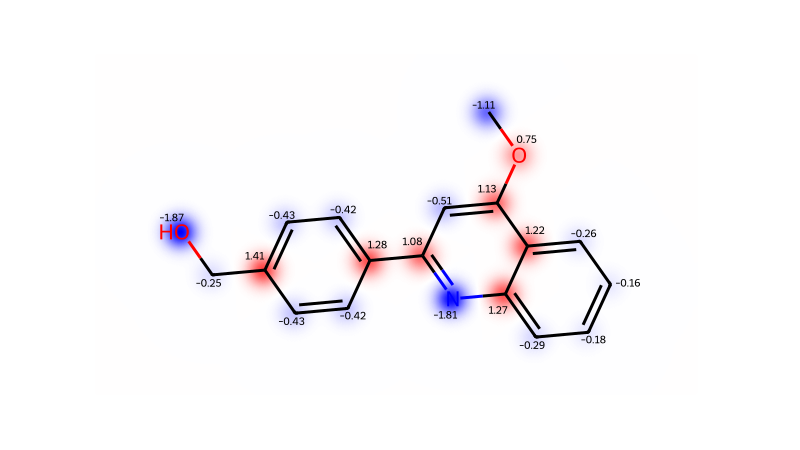

In [20]:
import sys
sys.path.append(ROOT_DIR)
from Source.explainers import visualize
from rdkit import Chem

# smiles = df["molecule"].unique().tolist()[4]
smiles = "COc1cc(-c2ccc(CO)cc2)nc2ccccc12"
mol = Chem.MolFromSmiles(smiles)
contribs = df[df["molecule"] == smiles].sort_values(by="atom", ascending=True)["contribution"].tolist()
print(contribs)
visualize(mol, contribs)